## Import Libraries and Download Dataset

Import required libraries and download the hand sign images dataset from Kaggle.

In [10]:
import kagglehub
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("ash2703/handsignimages")
print("✅ Dataset téléchargé ici :", path)

dataset_path = path
print(os.listdir(dataset_path))

✅ Dataset téléchargé ici : /home/zeldris10x/.cache/kagglehub/datasets/ash2703/handsignimages/versions/2
['Test', 'Train']


## Configure Image Parameters

Set image dimensions and batch size for training.

In [11]:
img_height, img_width = 32, 32
batch_size = 32

## Data Augmentation

Create data augmentation layers to improve model generalization.

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

## Load Datasets

Load training, validation, and test datasets from the downloaded directory.

In [13]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/Train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/Train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path + "/Test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("Classes :", class_names)

Found 27455 files belonging to 24 classes.
Using 21964 files for training.
Found 27455 files belonging to 24 classes.
Using 5491 files for validation.
Found 7172 files belonging to 24 classes.
Classes : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


## Optimize Data Pipeline

Apply caching, shuffling, and prefetching for better performance.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize Augmented Data

Display sample images with augmentation applied.

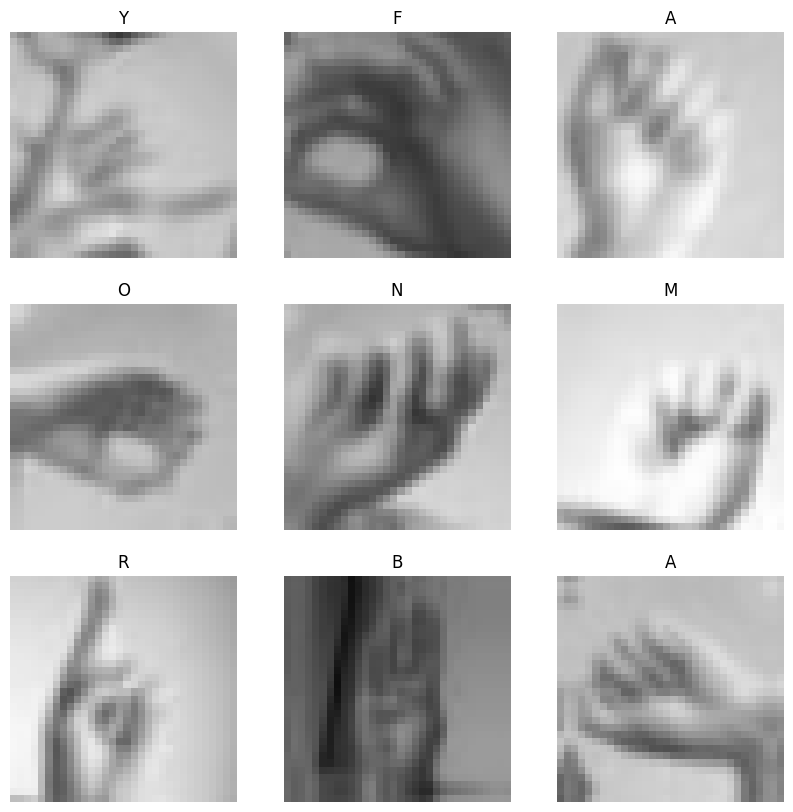

In [15]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    images = data_augmentation(images)
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Build CNN Model

Create a convolutional neural network with multiple layers and regularization.

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

## Compile Model

Configure the optimizer, loss function, and metrics.

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Setup Callbacks

Configure early stopping and learning rate reduction for training.

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

## Train Model

Train the model with the configured callbacks.

In [19]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.0990 - loss: 3.0240 - val_accuracy: 0.2125 - val_loss: 2.5007 - learning_rate: 0.0010
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.2185 - loss: 2.3732 - val_accuracy: 0.3686 - val_loss: 1.8205 - learning_rate: 0.0010
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.3771 - loss: 1.8128 - val_accuracy: 0.6241 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.4950 - loss: 1.4415 - val_accuracy: 0.6055 - val_loss: 1.1710 - learning_rate: 0.0010
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.5851 - loss: 1.1670 - val_accuracy: 0.7680 - val_loss: 0.6128 - learning_rate: 0.0010
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - accuracy: 0.6505 - loss: 0.9816 - val_accuracy: 0.7720 - val_loss: 0.6492 - learning_rate: 0.0010
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.7026 - l

## Evaluate Model

Test the model on the test dataset and display accuracy and loss.

In [20]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

225/225 - 4s - 17ms/step - accuracy: 0.9955 - loss: 0.0184

✅ Test Accuracy: 0.9955, Test Loss: 0.0184


## Plot Training History

Visualize accuracy and loss curves during training.

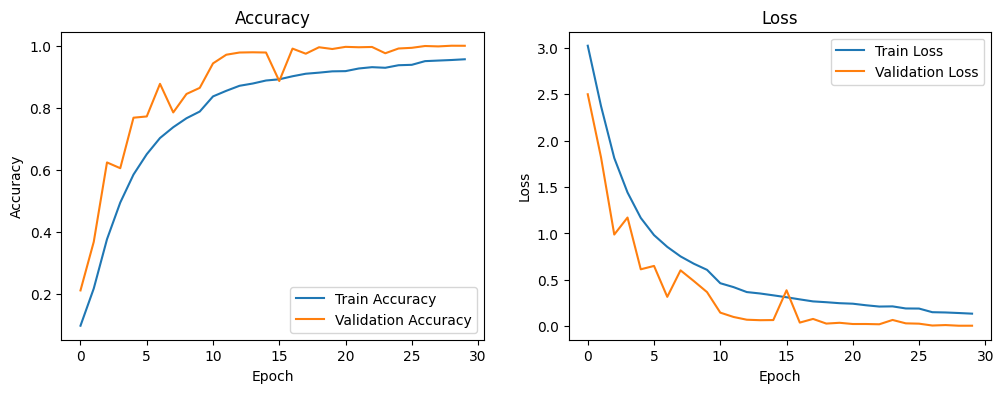

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()